# Setup and Get Data

In [ ]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

In [1]:
import os
import time
import uuid
import cv2

In [4]:
# Collecting Image
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [39]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
# Labeling the collected images
!labelme

# Review Dataset and Building Image Loading Function

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
# Loading images into TF Pipeline
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [5]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
type(images)

In [ ]:
# Reviewing Image with Matplotlib
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = image_generator.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# Splitting Unaugmented Data

### -MANUALLY SPLT DATA INTO TRAIN TEST AND VAL-

In [ ]:
# Moving match labels
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# Augmentation Of Data

In [6]:
import albumentations as alb

In [7]:
# Setting up the augmentor
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [ ]:
img = cv2.imread(os.path.join('data','train', 'images','3e000746-58a1-11ed-8d76-6c6a77ebe686.jpg'))

In [ ]:
with open(os.path.join('data', 'train', 'labels', '3e000746-58a1-11ed-8d76-6c6a77ebe686.json'), 'r') as f:
    label = json.load(f)

In [16]:
# Augmenting a sample image
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

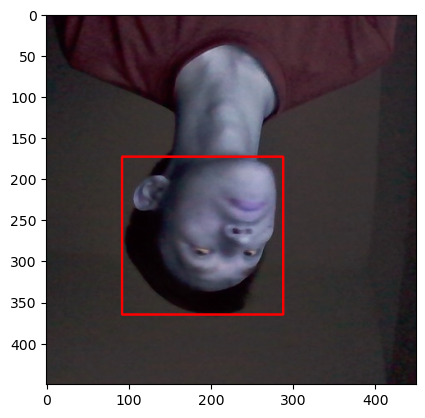

In [19]:
# Reviewing the result
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [8]:
# Building a augmentation pipeline for every image
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

Requested crop size (450, 450) is larger than the image size (302, 302)
Requested crop size (450, 450) is larger than the image size (388, 388)
Requested crop size (450, 450) is larger than the image size (388, 388)
image must be numpy array type
Requested crop size (450, 450) is larger than the image size (388, 388)
Requested crop size (450, 450) is larger than the image size (280, 326)
Requested crop size (450, 450) is larger than the image size (388, 388)
Requested crop size (450, 450) is larger than the image size (388, 388)
Requested crop size (450, 450) is larger than the image size (502, 335)
Requested crop size (450, 450) is larger than the image size (292, 500)
Requested crop size (450, 450) is larger than the image size (388, 388)
x_max is less than or equal to x_min for bbox [0.630597014925373, 0.2958126036484245, 0.3655161691542289, 0.720771144278607, 'face'].
x_max is less than or equal to x_min for bbox [0.6344838308457711, 0.2761194029850746, 0.37251243781094523, 0.71040

In [9]:
# Loading Images in a tensorflow dataset
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [10]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [11]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [44]:
train_images.as_numpy_iterator().next()

array([[[0.14748774, 0.13327205, 0.11856618],
        [0.13872549, 0.13167892, 0.11550245],
        [0.15067402, 0.14675245, 0.13039216],
        ...,
        [0.19589461, 0.16746323, 0.21403186],
        [0.1867647 , 0.15980393, 0.19705883],
        [0.1829044 , 0.16770834, 0.19068627]],

       [[0.15343137, 0.14166667, 0.10735294],
        [0.14895834, 0.13719362, 0.11072304],
        [0.15827206, 0.14650735, 0.12003677],
        ...,
        [0.1942402 , 0.1877451 , 0.20649509],
        [0.17990196, 0.18039216, 0.1882353 ],
        [0.19283088, 0.20067401, 0.19123775]],

       [[0.15686275, 0.1377451 , 0.1509804 ],
        [0.15196079, 0.13284314, 0.14607844],
        [0.14074755, 0.1216299 , 0.13584559],
        ...,
        [0.17990196, 0.17990196, 0.22598039],
        [0.18768382, 0.18768382, 0.22591911],
        [0.18051471, 0.18688725, 0.18443628]],

       ...,

       [[0.22824755, 0.25030637, 0.25471812],
        [0.24607843, 0.27745098, 0.2857843 ],
        [0.22745098, 0

# Preparing Labels

In [12]:
# Building load function for labels
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [13]:
# Load labels into tensorflow dataset
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [14]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [15]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [31]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.5063, 0.2502, 0.7495, 0.55  ], dtype=float16))

# Combining Label and Image Samples

In [16]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(7440, 7440, 1200, 1200, 2760, 2760)

In [17]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [18]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [19]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1500)
val = val.batch(8)
val = val.prefetch(4)

In [53]:
# Viewing image and annotations
data_samples = train.as_numpy_iterator()

In [64]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


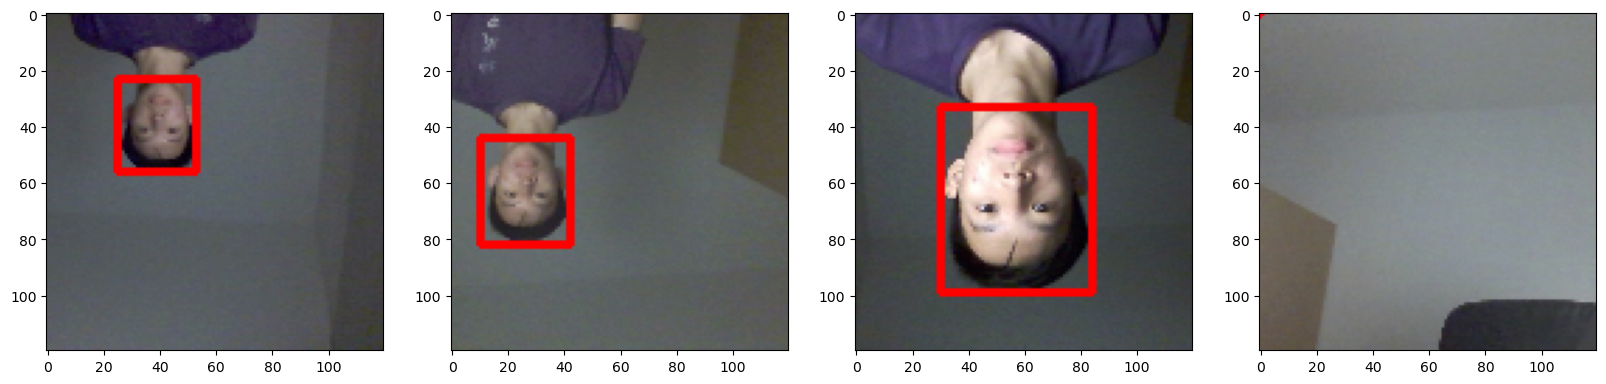

In [65]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Building Deep Learning using the Functional API

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [21]:
# downloading VGG16 model
vgg = VGG16(include_top=False)

In [41]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [22]:
# Building a instance of model network
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [23]:
facetracker = build_model()

In [24]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

# Defining Losses and Optimizers

In [25]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [26]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [27]:
# Creating classification loss and localization loss
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [28]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

# Training Neural Network

In [29]:
# creating custom model class
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [33]:
model = FaceTracker(facetracker)

In [34]:
model.compile(opt, classloss, regressloss)

In [35]:
logdir='logs'

In [36]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [37]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
930/930 [==============================] - 3853s 4s/step - total_loss: 0.0782 - class_loss: 0.0218 - regress_loss: 0.0674 - val_total_loss: 6.9014e-04 - val_class_loss: 2.0013e-05 - val_regress_loss: 6.8013e-04
Epoch 2/10
930/930 [==============================] - 3524s 4s/step - total_loss: 0.0068 - class_loss: 1.3907e-04 - regress_loss: 0.0067 - val_total_loss: 0.0046 - val_class_loss: 9.3215e-05 - val_regress_loss: 0.0045
Epoch 3/10
930/930 [==============================] - 3396s 4s/step - total_loss: 0.0048 - class_loss: 9.9383e-05 - regress_loss: 0.0048 - val_total_loss: 0.0038 - val_class_loss: 1.0267e-05 - val_regress_loss: 0.0038
Epoch 4/10
930/930 [==============================] - 3893s 4s/step - total_loss: 0.0031 - class_loss: 2.2498e-05 - regress_loss: 0.0031 - val_total_loss: 0.0020 - val_class_loss: 1.8179e-06 - val_regress_loss: 0.0020
Epoch 5/10
930/930 [==============================] - 3468s 4s/step - total_loss: 0.0028 - class_loss: 1.5476e-05 - regress_

In [38]:
# Plotting performance of training
hist.history

{'total_loss': [0.00562908872961998,
  0.00948698166757822,
  0.004984761122614145,
  0.004114345647394657,
  0.002369861351326108,
  0.0022557557094842196,
  0.0007819821476005018,
  0.001396676292642951,
  0.0012809163890779018,
  0.0019741649739444256],
 'class_loss': [4.989978697267361e-05,
  1.2040429282933474e-05,
  1.1809537681983784e-05,
  3.509239377308404e-06,
  2.9579009606095497e-06,
  2.697125182749005e-06,
  3.8743047525713337e-07,
  5.960471298749326e-07,
  6.705540158691292e-07,
  6.10948404755618e-07],
 'regress_loss': [0.0056041390635073185,
  0.009480961598455906,
  0.004978856537491083,
  0.004112591035664082,
  0.0023683824110776186,
  0.0022544071543961763,
  0.0007817884325049818,
  0.001396378269419074,
  0.0012805811129510403,
  0.0019738595001399517],
 'val_total_loss': [0.0006901414017193019,
  0.004593640100210905,
  0.003794753924012184,
  0.0020107137970626354,
  0.000566131726372987,
  0.003960996866226196,
  0.0006588654941879213,
  0.0007610772154293954

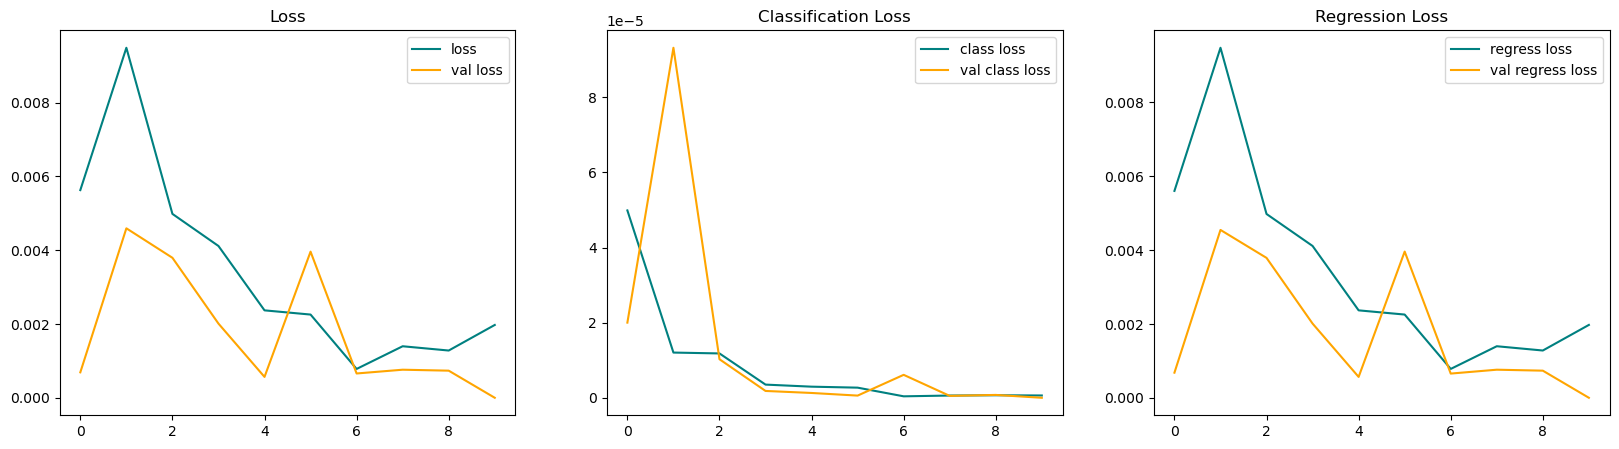

In [39]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# Making Predictions on Test Samples


In [40]:
test_data = test.as_numpy_iterator()

In [41]:
test_sample = test_data.next()

In [43]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


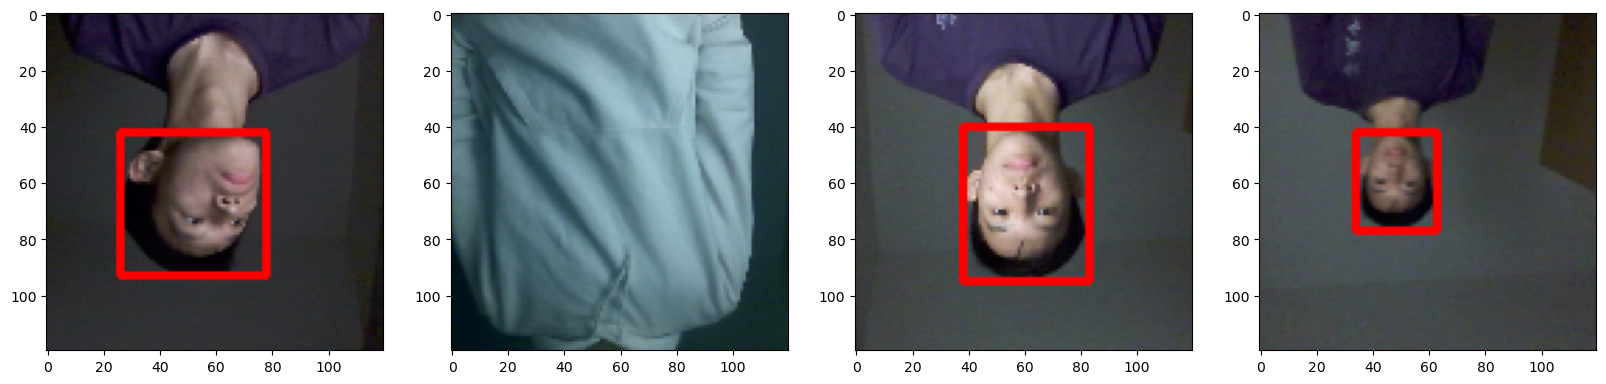

In [44]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [45]:
# Saving the model
from tensorflow.keras.models import load_model

In [46]:
facetracker.save('model4.h5')

In [47]:
facetracker = load_model('model4.h5')

# Real Time Detection

In [48]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = cv2.flip(frame, 1)
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'Ryan', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 159ms/step
